In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install torch==1.8.1+cu110 torchvision==0.6.0+cu110 -f https://download.pytorch.org/whl/torch_stable.html


In [7]:
from fastai.vision.all import *
from fastai.vision.gan import *

In [12]:
import fastai
from fastai.vision import *
from fastai.vision.gan import *

In [9]:
path = untar_data(URLs.PETS)
in_path = path/'images'
out_path = path/'lowres'

In [10]:
from PIL import Image, ImageDraw, ImageFont

class image_changer(object):

  def __init__(self, out_path, in_path):
    self.out_path = out_path
    self.in_path = in_path

  def __call__(self, f, i):
    pass 

class lowres_images(image_changer):

  def __init__(self, out_path, in_path):
    super().__init__(out_path, in_path)

  def __call__(self, f, i):
    dest = self.out_path/f.relative_to(self.in_path)    
    dest.parent.mkdir(parents=True, exist_ok=True)
    image = PIL.Image.open(f)
    size_to = resize_to(image, 96, use_min=True)
    image = image.resize(size_to, resample=PIL.Image.BILINEAR).convert('RGB')
    image.save(dest, quality=random.randint(10,60))


class bw_images(image_changer):

  def __init__(self, out_path, in_path):
    super().__init__(out_path, in_path)

  def __call__(self, f, i):
    dest = self.out_path/f.relative_to(self.in_path)    
    dest.parent.mkdir(parents=True, exist_ok=True)
    image = PIL.Image.open(f)
    image = image.convert('LA')
    image.save(dest)


class bw_lowres_images(image_changer):

  def __init__(self, out_path, in_path):
    super().__init__(out_path, in_path)

  def __call__(self, f, i):
    dest = self.out_path/f.relative_to(self.in_path)    
    dest.parent.mkdir(parents=True, exist_ok=True)
    image = PIL.Image.open(f)
    size_to = resize_to(image, 96, use_min=True)
    image = image.resize(size_to, resample=PIL.Image.BILINEAR).convert('LA')
    image.save(dest, quality=random.randint(10,60))


# MODIFY DATASET

Execute only first time if using google-drive (it takes time), if not using drive, execute only first time if new runtime (files are not there). 

In [11]:
il = ImageList.from_folder(in_path)
parallel(lowres_images(out_path, in_path), il.items)

NameError: name 'ImageList' is not defined

In [ ]:
src = ImageImageList.from_folder(out_path).split_by_rand_pct(0.1, seed=42)


Size can change  (128, 160, 256) depending on resolution. bs (batch size) also (32, 24, 8). This affects GPU memory. 

In [ ]:
data = (src.label_from_func(lambda x: in_path/x.name)
           .transform(get_transforms(max_zoom=2.), size=128, tfm_y=True)
           .databunch(bs=32).normalize(imagenet_stats, do_y=True))
data.c = 3



In [ ]:
learn =  unet_learner(data, models.resnet34, wd=1e-3, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=(-3.0,3.0), loss_func=MSELossFlat())

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(2, pct_start=0.8)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, slice(1e-6,1e-3))

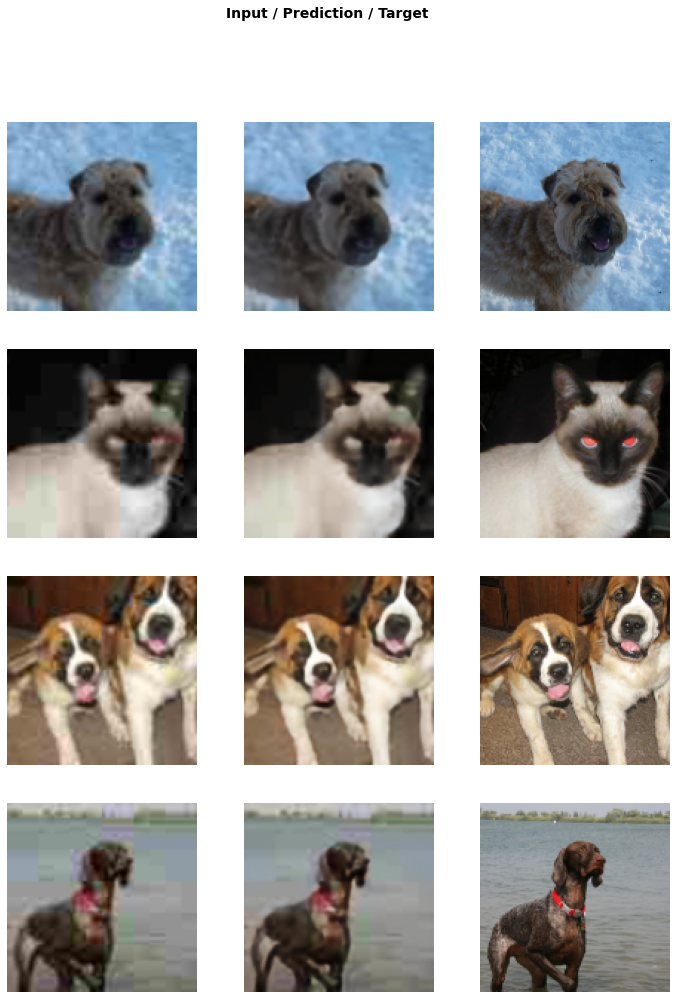

In [ ]:
learn.show_results(rows=4)

In [ ]:
learn.save('generator')

# GAN

As our loss function is not working, we are going for a different approach: GAN (Generative Adversarial Network). Where the loss function is another network model, the Critic, we are trying to fool. 



In [ ]:
learn_g = learn.load('generator')

In [ ]:
gen_path = path/'generated'

In [ ]:
gen_path.mkdir(exist_ok=True)

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_g.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(gen_path/names[i].name)
            i += 1

In [ ]:
save_preds(data.fix_dl)

# Critic Network

In [ ]:
learn = None
learn_g = None
# FREE UP MEMORY
gc.collect()

268

In [ ]:
src = ImageList.from_folder(path, include=['generated','images']).split_by_rand_pct(0.1, seed=42)

In [ ]:
labs = src.label_from_folder(classes=['generated','images'])

## SIZE/BS

Should be the same used above (parameter better)

In [ ]:
data = (labs.transform(get_transforms(max_zoom=2.), size=128).databunch(bs=32).normalize(imagenet_stats))
data.c = 3

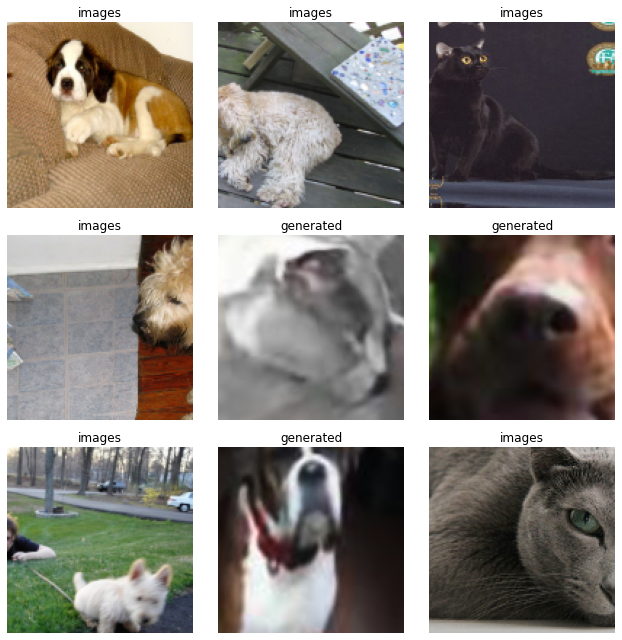

In [ ]:
data.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
learn = Learner(data, gan_critic(), metrics=accuracy_thresh_expand, loss_func=AdaptiveLoss(nn.BCEWithLogitsLoss()), wd=1e-3)

In [ ]:
learn.fit_one_cycle(6, 1e-3)

In [ ]:
learn.save('critic')

# GAN 

We combine both models in a GAN

In [ ]:
learn = None
gc.collect()

19724

Create Critic


In [ ]:
src_c = ImageList.from_folder(path, include=['generated','images']).split_by_rand_pct(0.1, seed=42)
labs_c = src_c.label_from_folder(classes=['generated','images'])
data_c = (labs_c.transform(get_transforms(max_zoom=2.), size=128).databunch(bs=32).normalize(imagenet_stats))
data_c.c = 3

In [ ]:
learn_c = Learner(data_c, gan_critic(), metrics=accuracy_thresh_expand, loss_func=AdaptiveLoss(nn.BCEWithLogitsLoss()), wd=1e-3)
learn_c.load('critic')

Learner(data=ImageDataBunch;

Train: LabelList (12637 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
generated,generated,generated,generated,generated
Path: /root/.fastai/data/oxford-iiit-pet;

Valid: LabelList (1404 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
images,images,images,generated,images
Path: /root/.fastai/data/oxford-iiit-pet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Dropout2d(p=0.075, inplace=False)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
        (0): Con

Create Generator

In [ ]:
src_g = ImageImageList.from_folder(out_path).split_by_rand_pct(0.1, seed=42)
data_g = (src_g.label_from_func(lambda x: in_path/x.name)
           .transform(get_transforms(max_zoom=2.), size=128, tfm_y=True)
           .databunch(bs=32).normalize(imagenet_stats, do_y=True))
data_g.c = 3

In [ ]:
learn_g =  unet_learner(data_g, models.resnet34, wd=1e-3, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=(-3.0,3.0), loss_func=MSELossFlat())
learn_g.load('generator')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/lowres;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/lowres;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilatio

**switcher**  Moves from training the generator to training the critic (and viceversa) when loss is over > 0.65


In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

Our learner is a GAN Learner, built from both models (learn_g and learn_c). 

In [ ]:
learn = GANLearner.from_learners(learn_g, learn_c, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=1e-3)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

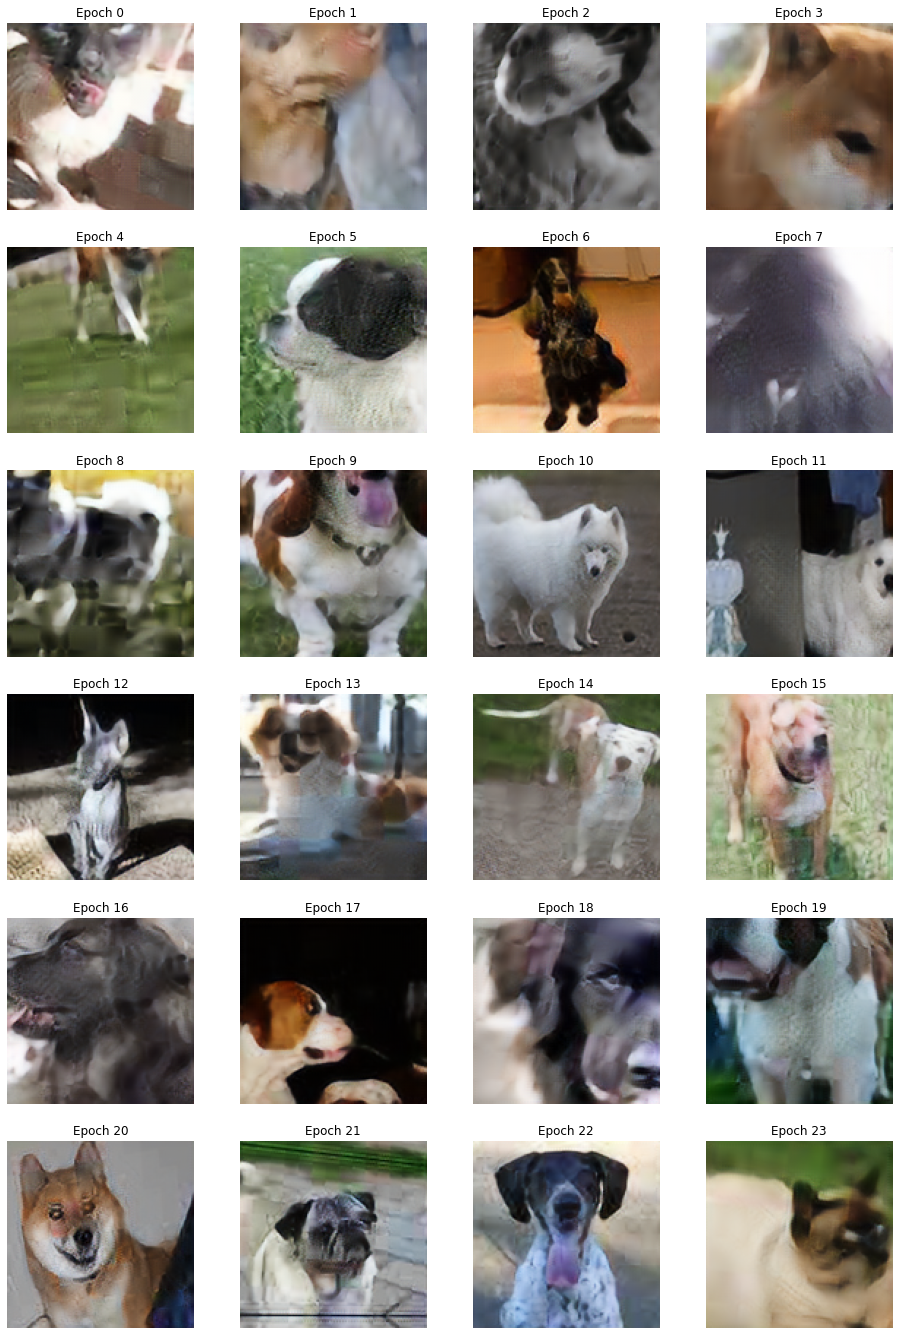

Buffered data was truncated after reaching the output size limit.

In [57]:
learn.fit(30, 1e-4)

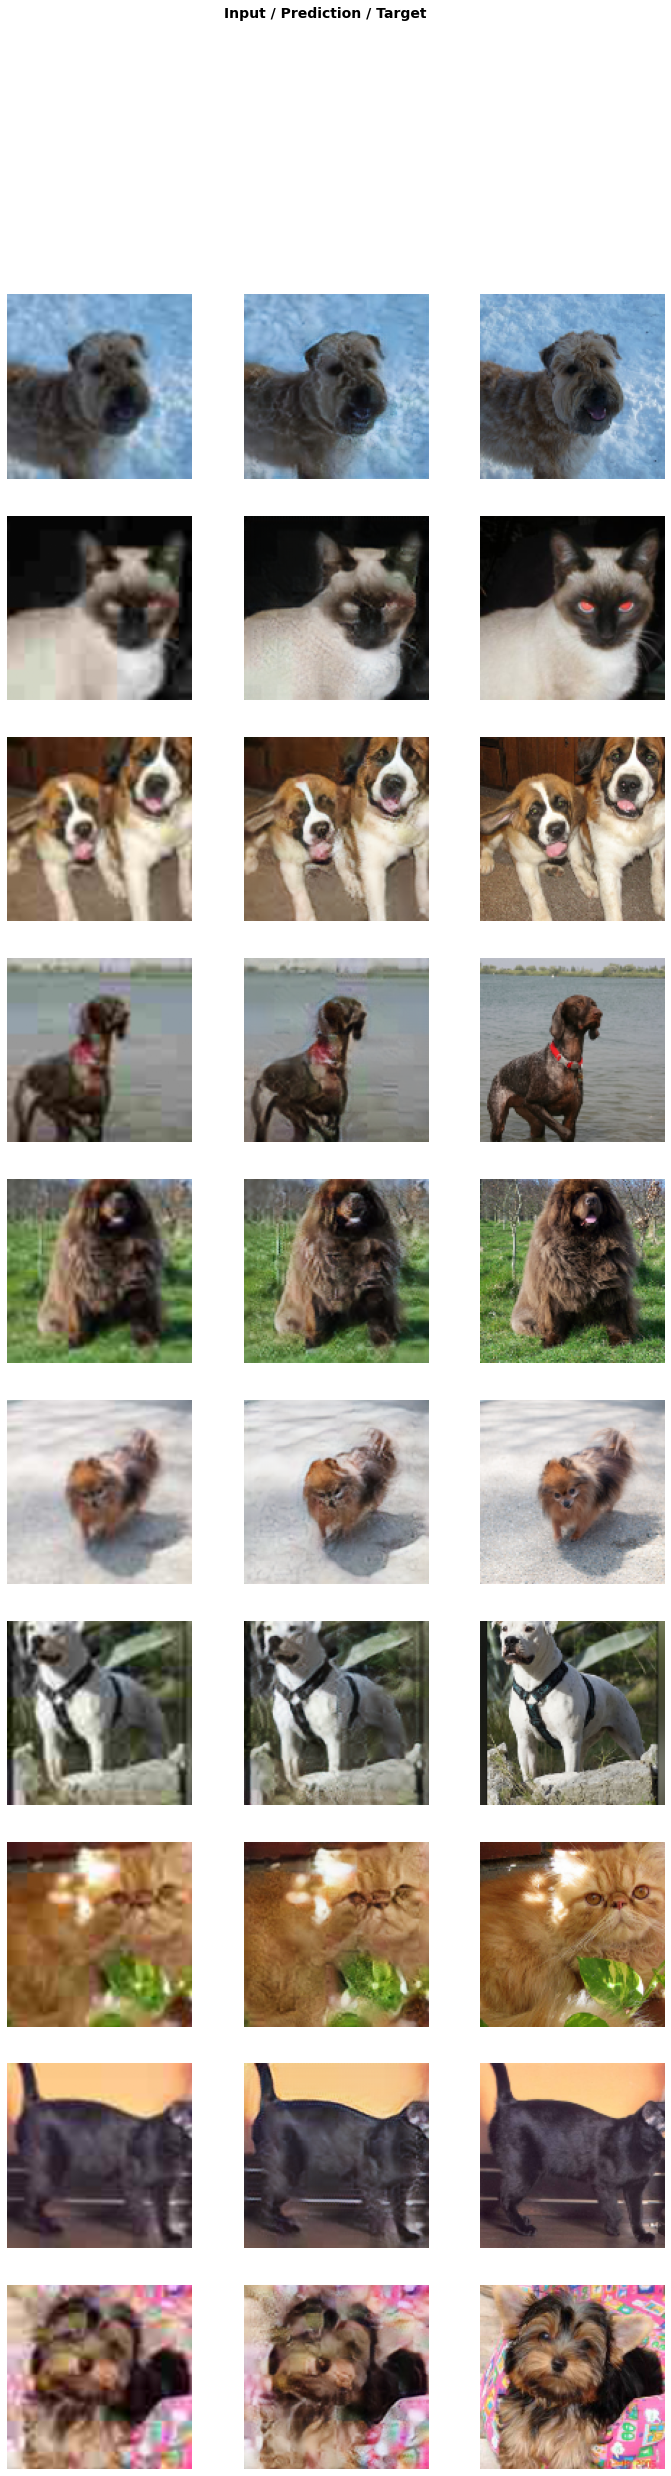

In [58]:
learn.show_results(rows=10)

In [59]:
learn.save('gan-1')